In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('../'))
import utils.osm_helper
reload(utils.osm_helper)
import utils.geofunc
reload(utils.geofunc)
from utils.osm_helper import *
import geopandas as gp
%matplotlib inline

from osmread import parse_file, Node, Way, Relation

In [2]:
DCOSM_DATA_PATH = '../data/washingtonDC.osm'
OUTPUT_DIR = '../data/output/'

In [3]:
OSM_DATA = osm_container(DCOSM_DATA_PATH)
print OSM_DATA.data_size()

begin reading osm 2016-11-08 15:56:51.791000
finish reading osm 2016-11-08 15:58:02.842000
["len of <class 'osmread.elements.Relation'> = 3427", "len of <class 'osmread.elements.Node'> = 2546260", "len of <class 'osmread.elements.Way'> = 306332"]


{'LineString': [],
 'Point': [],
 'Polygon': [<shapely.geometry.polygon.Polygon at 0xbbaf3128>,
  <shapely.geometry.polygon.Polygon at 0xbbaf36d8>]}

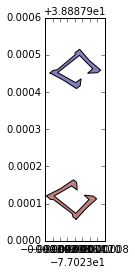

In [4]:

from shapely.ops import linemerge

rid = 1024009 # two nodes
rid = 162069 # 1 node inside a poly(formed by multiple ways)
rid = 6276447
# rid = 3147913 
# rid = 1024022
rid = 3461574
shpcltn = rltn2cltn(OSM_DATA,OSM_DATA.get_osm_relation_by_id(rid))
# cltn[Way][0].is_closed, cltn[Way][0].is_ring
gp.GeoDataFrame(shpcltn['Polygon'][:2], columns=['geometry']).plot()
# shpcltn['LineString'][0].is_closed
shpcltn

In [5]:
def get_all_merge_shp(osm_data):
    result = []
    for r in osm_data.osm_objs[Relation]:
        merge_shpcltn, status = rltn2mergedCltn(osm_data, r)
        if status!='error':
            result.append((r.id,merge_shpcltn))
    return result

all_merge_shp = get_all_merge_shp(OSM_DATA)
len(all_merge_shp)

50372 relation's member out of osm bound, no need to consider 113295049L
62152 relation's member out of osm bound, no need to consider 215634L
112245 relation's member out of osm bound, no need to consider 2297232L
133366 relation's member out of osm bound, no need to consider 34313742L
133386 relation's member out of osm bound, no need to consider 34314601L
133393 relation's member out of osm bound, no need to consider 34314461L
133482 relation's member out of osm bound, no need to consider 34317348L
133492 relation's member out of osm bound, no need to consider 34317467L
133501 relation's member out of osm bound, no need to consider 34317475L
133513 relation's member out of osm bound, no need to consider 34303757L
133514 relation's member out of osm bound, no need to consider 34314019L
133518 relation's member out of osm bound, no need to consider 404669425L
133524 relation's member out of osm bound, no need to consider 34317735L
133564 relation's member out of osm bound, no need to 

3255

In [6]:
all_merge_shp[2]

(133257L,                                             geometry
 0  POLYGON ((-77.0230656 38.9844373, -77.02280880...)

In [7]:
lens = []
for rid, x in all_merge_shp:
    lens.append((rid, x.shape[0]))
df = pd.DataFrame(lens)
df[df[1]==2]
# df[1].value_counts()

,0,1
10,133295,2
27,133392,2
44,133558,2
48,133787,2
51,180413,2
82,359775,2
139,381400,2
292,382190,2
497,914117,2
552,914218,2


In [8]:
from collections import defaultdict
def get_relation_component_pattern(osm_data):
    patterns = defaultdict(list)
    for rid in osm_data.osm_objs_idx[Relation].keys():
        try:
            shpcltn = rltn2cltn(osm_data,OSM_DATA.get_osm_relation_by_id(rid))
            pts, lns, polys = shpcltn['Point'], shpcltn['LineString'], shpcltn['Polygon']
            len_pts, len_lns, len_polys = len(pts), len(lns), len(polys)
            patterns[(len_pts, len_lns, len_polys)].append(rid)
        except Exception as e:
#             print rid, e
            pass
    return patterns
patterns = get_relation_component_pattern(OSM_DATA)

In [9]:
import pandas as pd
nl = []
for k,v in patterns.items():
    l = list(k)
    l.append(k)
    l.append(v)
    nl.append(l)
    
df = pd.DataFrame(nl,columns=['len_pts', 'len_lns', 'len_poly','pattern' ,'rids'])
df['len_rids'] = df.rids.apply(len)
df.sort('len_rids', ascending=False)
# df[df['len_poly']>0].sort('len_rids', ascending=False)

,len_pts,len_lns,len_poly,pattern,rids,len_rids
78,0,0,2,"(0, 0, 2)","[3147913, 5575406, 966793, 1343680, 1343706, 1...",978
35,1,1,0,"(1, 1, 0)","[6276447, 6260066, 5259358, 5259359, 5259360, ...",812
32,0,0,1,"(0, 0, 1)","[1024018, 1024041, 1024045, 4636922, 4727063, ...",261
31,0,0,3,"(0, 0, 3)","[6353655, 3203318, 1859839, 6275362, 3424612, ...",256
9,2,0,1,"(2, 0, 1)","[1024010, 1024019, 1024020, 1024021, 1024022, ...",153
24,1,0,1,"(1, 0, 1)","[4636685, 4644966, 4644996, 4645026, 4645075, ...",151
76,0,0,4,"(0, 0, 4)","[3924707, 6033563, 1074362, 1140776, 3213622, ...",97
19,0,1,0,"(0, 1, 0)","[6276467, 3192181, 4645121, 5946395, 4633767, ...",87
30,0,0,5,"(0, 0, 5)","[6628305, 2999471, 6628247, 1115965, 1364340, ...",56
73,0,0,6,"(0, 0, 6)","[1891511, 1154135, 1067786, 2837736, 913964, 9...",47


In [67]:
mask = df['pattern']==(0, 2, 0, 2, 2) # amenity, building
# mask = df['pattern']==(1,1,0,0,0) # road resetriction, 5 boundary of place=*(neighbourhood),1 cycle_network
mask = df['pattern']==(1,1,0,1,1)  # mostly boundary, admin_level, 7 restriction
# mask = df['pattern']==(1,1,0,1,0) # road/turn restriction
mask = df['pattern']==(1, 2, 0, 0, 0)# restriction
mask = df['pattern']==(4, 1, 0, 1, 1)# restriction
l_tags = []
for rid in df[mask].rids.values[0]:
    r = OSM_DATA.get_osm_relation_by_id(rid)
#     print rid,r.tags
    l_tags.append(tuple(r.tags.keys()))
print pd.Series(l_tags).value_counts()

(type,)                   11
(building, type, name)     1
(type, name)               1
dtype: int64


In [105]:
def get_member_tags(osm_data, osm_r):
    member_tags = defaultdict(set)
    for m in osm_r.members:
        obj = osm_data.get_osm_obj_by_id(m.type, m.member_id)
        for t, v in obj.tags.items():
            member_tags[t].add(v)
    return member_tags
rid = 1024009 # two nodes
rid = 162069 # 1 node inside a poly(formed by multiple ways)
rid = 6276447
rid = 3147913  
rid = 3461574
osm_r = OSM_DATA.get_osm_relation_by_id(rid)
print get_member_tags(OSM_DATA,osm_r )
print osm_r.tags


defaultdict(<type 'set'>, {u'building': set([u'yes']), u'website': set([u'http://www.hirshhorn.si.edu/']), u'name': set([u'Hirshhorn Museum']), u'building:material': set([u'concrete']), u'opening_hours': set([u'Mo-Su 07:30-17:30']), u'roof:material': set([u'concrete']), u'wikipedia': set([u'en:Hirshhorn Museum and Sculpture Garden']), u'height': set([u'5', u'25.4']), u'min_height': set([u'5']), u'building:part': set([u'yes', u'no']), u'operator': set([u'Smithsonian Institution']), u'tourism': set([u'museum']), u'type': set([u'multipolygon'])})
{u'type': u'building', u'description': u'Hirshhorn Museum'}
